####**1. 데이터 선정 이유**

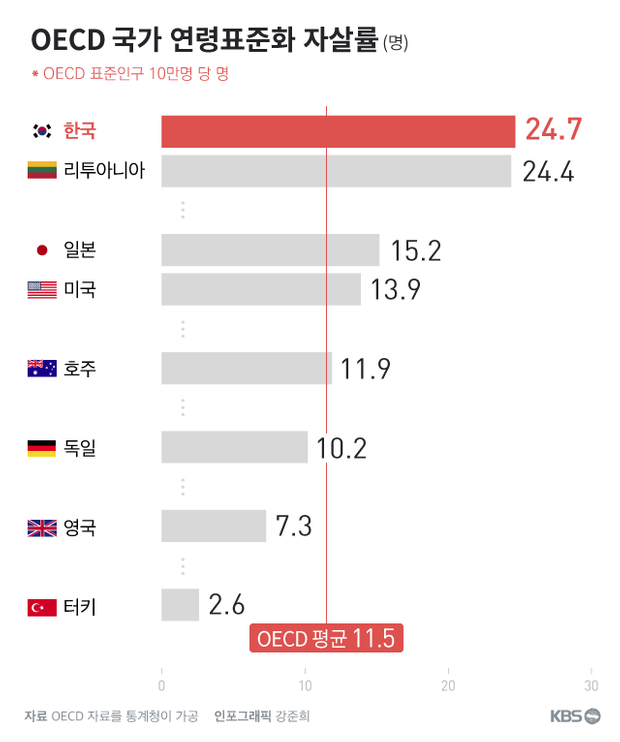

한국은 노인들의 자살률이 OECD 평균 11.5를 넘어서는 것은 물론이고,
노인 자살이 사회의 심각한 문제로 떠오르고 있습니다.

노인자살 예방이 필수적인 사회의 문제로 떠오르고 있습니다.

하지만 자살의 가능성을 판단하는 것은 쉽지 않습니다.
직접적으로 물어보면 비교적 옳지 않은 결과가 나올 것이기 때문입니다.
또한 예의에 어긋날 수 있는 문제가 있습니다. 

그래서 노인 분들이 가장 많이 모이는 종묘 탑골공원 주변에서 여가 생활 설문조사를 시행하였고, 중간에 삶에대한 만족도를 5단계로 분류하여 
만족하지 못하는 노인분들을 위험군으로 분류했습니다.
(1)

하지만 삶에대한 만족도 또한 예의에 맞지 않는 질문이므로 
앞으로는 겉으로 드러나지 않게 위험군을 체크할 수 있는
머신러닝 모델을 만들려고 합니다.




가설은 아래와 같습니다. 

- 만족도가 매우 낮은 경우 자살을 할 확률이 높다.



**[종묘탑골공원 주변어르신 실태와 욕구조사]**

 설문조사를 이용하여 어르신들의 삶에 대한 만족도를 분류하는 모델을 만들어 보도록 하겠습니다.

####**데이터 전처리**

In [ ]:
!pip install --upgrade category_encoders

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn
import os
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score
from category_encoders import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [5]:
df = pd.read_excel('/content/gdrive/MyDrive/data/sc231/1. MD_2016년 어르신 여가생활 설문조사_개별면접.xlsx')

In [6]:

df = df.replace({'DQ63': {1: 1, 2:1 , 3:2, 4:2, 5:2}})
df
#타겟 변수를 바꾸어 주도록 하겠습니다.

,ID,SQ0,SQ1,SQ2,SQ3,Q01,Q021,Q022,Q023,Q024,Q03,Q041,Q04101,Q04102,Q04103,Q04104,Q04105,Q04106,Q042,Q04201,Q04202,Q04203,Q04204,Q04205,Q04206,Q04207,Q043,Q04301,Q04302,Q04303,Q04304,Q04305,Q04306,Q04307,Q04308,Q04309,Q04310,Q05,Q051,Q05101,...,Q3201,Q3202,Q3203,Q3204,Q3205,Q3206,Q33,Q34,Q3401,Q3402,Q3403,Q3404,Q3405,Q35,Q3501,Q36,Q37,Q381,Q382,Q383,Q391,Q392,Q393,Q394,Q395,Q40,Q401,Q411,Q412,Q42,DQ1,DQ2,DQ3,DQ4,DQ5,DQ61,DQ62,DQ63,DQ64,DQ65
0,1,1,1,2,1,2,2,12,2,16,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,2,3,4,5,#NULL!,#NULL!,#NULL!,5,7,3,5,2,2,2,1,1,2,2,2,1,3,1,0,15000,1,1949,1,4,3,3,2,1,2,1
1,2,1,1,2,1,2,2,13,2,16,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,3,5,#NULL!,#NULL!,#NULL!,#NULL!,6,7,3,4,2,2,2,1,1,2,2,2,1,13,0,15,10000,1,1948,2,1,2,3,3,1,2,3
2,3,1,1,2,1,2,1,11,2,15,1,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,2,8,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,1,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,3,2,3,5,#NULL!,#NULL!,#NULL!,6,7,3,3,2,2,2,2,1,2,2,2,1,3,1,10,25000,1,1950,2,1,2,3,2,2,2,3
3,4,1,1,2,1,2,2,12,2,16,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,3,3,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,5,7,3,4,2,2,2,1,1,2,2,2,1,13,0,10,10000,1,1949,2,1,2,3,3,1,2,3
4,5,1,1,2,1,2,2,15,2,17,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,2,3,5,#NULL!,#NULL!,#NULL!,#NULL!,5,7,3,4,2,2,2,1,1,2,2,2,1,5,0,20,15000,1,1948,1,2,3,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,620,3,1,2,1,2,1,10,2,16,1,3,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,4,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,6,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,1,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,3,3,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,6,3,3,2,2,2,2,1,2,2,1,1,16,1,0,12000,1,1948,2,1,2,2,2,2,3,3
519,621,5,1,2,1,3,2,12,2,17,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,1,2,#NULL!,#NULL!,#NULL!,#NULL!,3,4,2,2,1,1,1,2,1,2,2,2,1,3,1,0,35000,1,1946,2,1,4,2,4,2,3,3
520,622,5,1,2,1,2,2,13,2,18,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,4,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,1,1,2,#NULL!,#NULL!,#NULL!,#NULL!,3,4,2,2,2,2,1,2,1,1,2,2,1,21,1,10,20000,1,1944,2,1,4,3,4,2,3,2
521,623,5,1,2,1,3,2,12,2,17,2,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,...,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,#NULL!,3,1,2,#NULL!,#NULL!,#NULL!,#NULL!


DQ63 (동의 정도) 나는 내 인생에 만족한다 /라는 숨겨진 타겟변수를 살펴보도록 하겠습니다.

1. 전혀 그렇지 않다.
2. 그렇지 않다.
3. 그저 그렇다
4. 그렇다.
5. 매우 그렇다.

1과 2를 위험군으로 분류합니다.

2    0.543021
1    0.456979
Name: DQ63, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


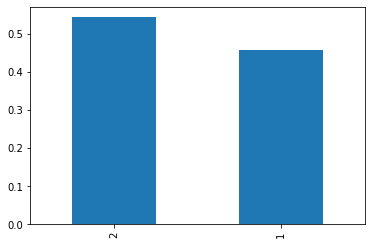

In [7]:
target = 'DQ63'
print(df[target].value_counts(normalize=True))
print(df[target].value_counts(normalize=True).plot.bar())

밸런스가 어느정도 맞추어져 있습니다. 

#NULL!    0.491396
2         0.231358
3         0.139579
1         0.095602
5         0.032505
4         0.005736
6         0.003824
Name: Q041, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


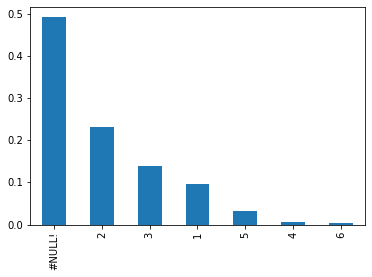

In [8]:
print(df['Q041'].value_counts(normalize=True))
print(df['Q041'].value_counts(normalize=True).plot.bar())

오전 시간에 자주 머무르는 지역(중복응답)

2. 탑골공원과 주변거리 
3. 낙원상가

두 항목이 가장 큰 값을 차지하고 
Null 값은 결측치가 아니라 미응답입니다.
절반이 미응답을 고른것으로 확인됩니다.


설문조사 파일이라 딱히 전처리를 할 필요가 없어 보입니다.

In [9]:
#열 타입이 정수 97개 오브젝트형 139 개 입니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Columns: 236 entries, ID to DQ65
dtypes: int64(97), object(139)
memory usage: 964.4+ KB


In [10]:
df.isnull().sum().sort_values(ascending = False)
#결측치 확인

DQ65      0
Q09101    0
Q09206    0
Q09205    0
Q09204    0
         ..
Q2221     0
Q2213     0
Q2212     0
Q2211     0
ID        0
Length: 236, dtype: int64

결측치는 없습니다.Null 값은 결측치가 아니라 미응답입니다.

In [11]:
#검증 트레이닝 데이터 나누기
target = 'DQ63'

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)
train.shape, test.shape

((418, 236), (105, 236))

In [12]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((334, 236), (84, 236), (105, 236))

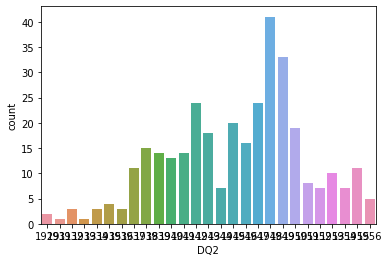

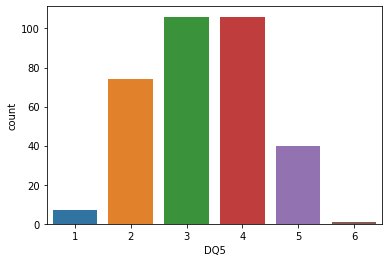

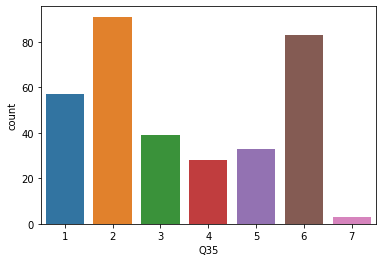

In [13]:
sns.countplot(x="DQ2", data=train) #태어난 년도 
plt.show();
sns.countplot(x="DQ5", data=train)
plt.show(); # 최종학력 1.무학 2. 초 3.중 4.고 5.대 6.대학원
sns.countplot(x="Q35", data=train)
plt.show();#향후 종묘/탑골공원 주변에 어르신들을 위한 시설 생긴다면, 우선적으로 필요한 시설(중복응답) 2. 복지시설 5. 무료급식시설

In [15]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]


X_train.shape, X_val.shape,y_train.shape, y_val.shape, X_test.shape ,y_test.shape

((334, 235), (84, 235), (334,), (84,), (105, 235), (105,))

####**모델 생성**

타겟이 밸런스 있는 피쳐이지만 
정확도 뿐만아니라 
리컬, 프레시전, 그리고 이둘을 조합한 F1 score 을 사용하도록 하겠습니다! 

In [16]:
pipe_decision = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2,max_depth=10)
)
  
pipe_decision.fit(X_train, y_train)

print()
print("train 정확도: ", pipe_decision.score(X_train, y_train))
print("validation 정확도: ", pipe_decision.score(X_val, y_val))
#f1
y_pred_decision = pipe_decision.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_decision))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train 정확도:  1.0
validation 정확도:  0.7738095238095238
validation f1_score:  0.732394366197183


트리 구성을 확인해 보겠습니다.

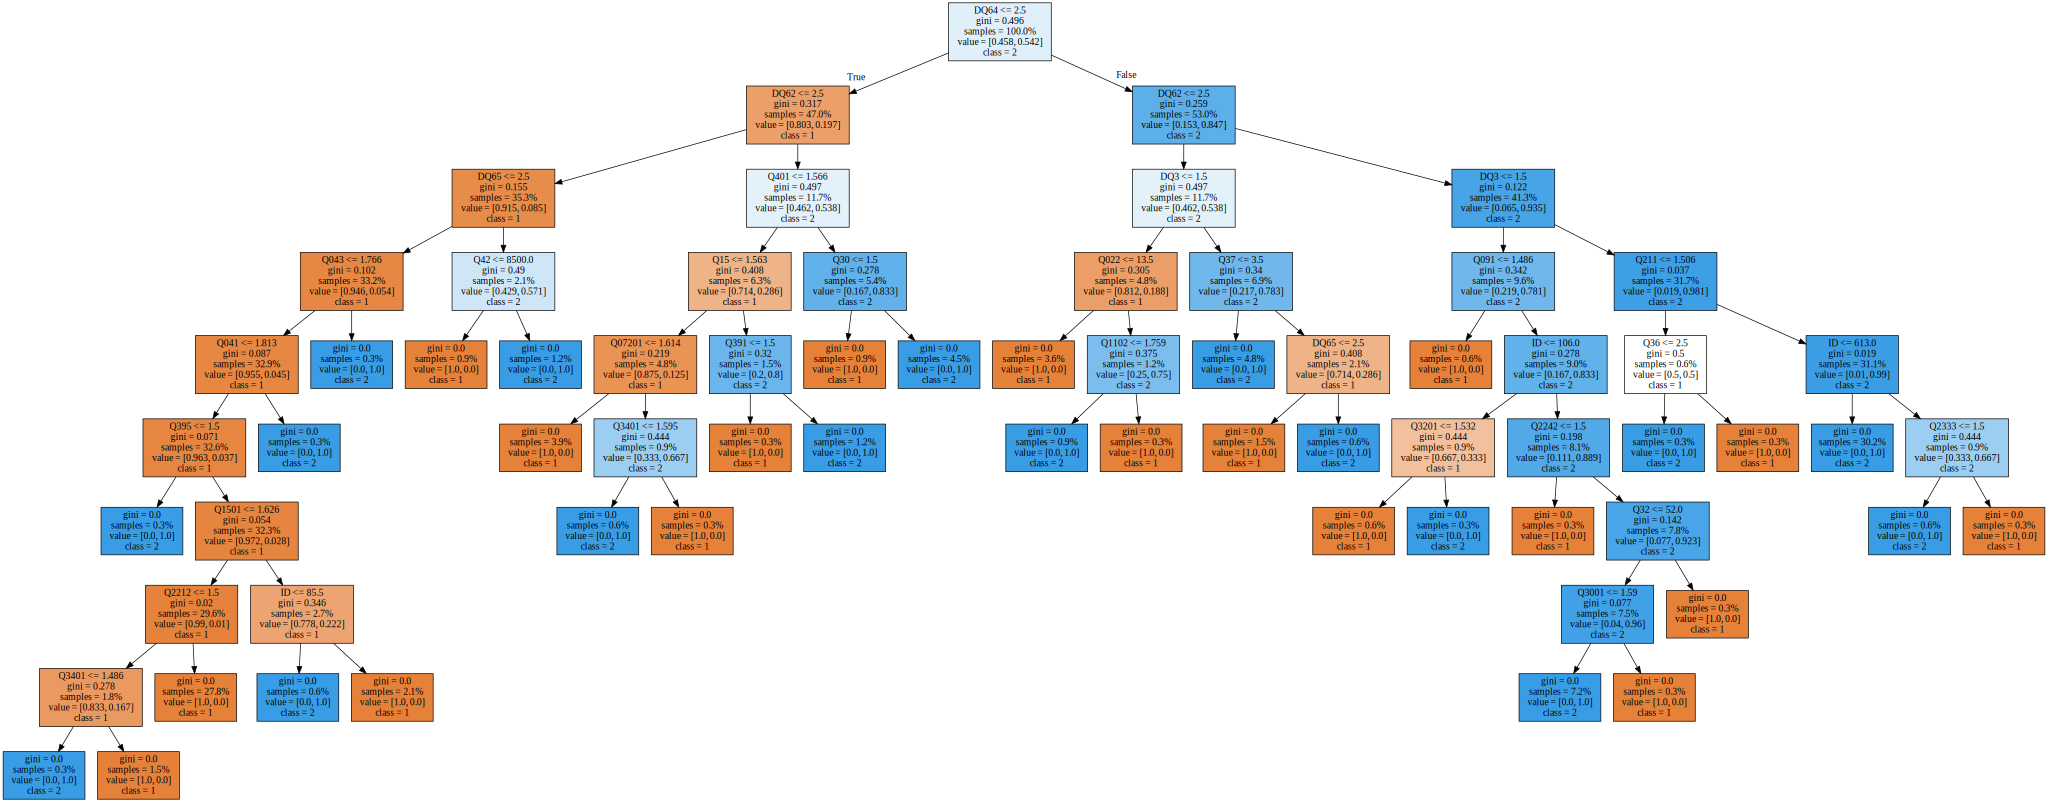

In [17]:
import graphviz
from sklearn.tree import export_graphviz

tree = pipe_decision.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

DQ64행은  = (동의 정도) 지금까지 나는 내 인생에서 원했던 중요한 것들을 가질 수 있었다 이므로 삶의 만족도 타겟 피쳐에 유출될 가능성이 큽니다. 삭제해 주도록 하겠습니다.

DQ62행은  = (동의 정도) 내 인생의 여건들은 매우 좋은 편이다

DQ65행은 - (동의 정도) 다시 산다고 하더라도 지금처럼 살고 싶다

둘다 유출의심되므로 삭제해주도록 하겠습니다.

In [18]:
features = df.columns.drop([target
                            , 'DQ64'
                            , 'DQ62'
                            , 'DQ65'
                           ])

In [19]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]


X_train.shape, X_val.shape,y_train.shape, y_val.shape, X_test.shape ,y_test.shape

((334, 232), (84, 232), (334,), (84,), (105, 232), (105,))

다시 모델을 만들겠습니다.

In [20]:
pipe_decision = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2,max_depth=10)
)
  
pipe_decision.fit(X_train, y_train)

print()
print("train 정확도: ", pipe_decision.score(X_train, y_train))
print("validation 정확도: ", pipe_decision.score(X_val, y_val))
#f1
y_pred_decision = pipe_decision.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_decision))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train 정확도:  0.9910179640718563
validation 정확도:  0.6428571428571429
validation f1_score:  0.6341463414634148


과적합이 일어났습니다.
다른 모델도 만들어 보겠습니다.

In [22]:
from xgboost import XGBClassifier

pipe1 = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    XGBClassifier()
)

pipe1.fit(X_train, y_train);

print()
print("train 정확도: ", pipe1.score(X_train, y_train))
print("validation 정확도: ", pipe1.score(X_val, y_val))
#f1
y_pred_xgb = pipe1.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_xgb))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train 정확도:  0.9940119760479041
validation 정확도:  0.7261904761904762
validation f1_score:  0.7012987012987013


In [23]:
# 랜덤 포레스트 모델
pipe6 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)
  
pipe6.fit(X_train, y_train)

print()
print("train 정확도: ", pipe6.score(X_train, y_train))
print("validation 정확도: ", pipe6.score(X_val, y_val))
#f1
y_pred_random = pipe6.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_random))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train 정확도:  1.0
validation 정확도:  0.7738095238095238
validation f1_score:  0.7532467532467534


In [24]:
print("y_pred_decision validation f1_score: ", f1_score(y_val, y_pred_decision))
print("y_pred_xgb validation f1_score: ", f1_score(y_val, y_pred_xgb))
print("y_pred_random validation f1_score: ", f1_score(y_val, y_pred_random))

y_pred_decision validation f1_score:  0.6341463414634148
y_pred_xgb validation f1_score:  0.7012987012987013
y_pred_random validation f1_score:  0.7532467532467534


랜덤 포레스트 모델이 가장 성능이 뛰어납니다. 
하이퍼 파라미터를 튜닝해 주겠습니다.

In [25]:
sorted(pipe6.get_params().keys())
#하이퍼 파라미터 조절가능한 것들을 나열하겠습니다.

['memory',
 'randomforestclassifier',
 'randomforestclassifier__bootstrap',
 'randomforestclassifier__ccp_alpha',
 'randomforestclassifier__class_weight',
 'randomforestclassifier__criterion',
 'randomforestclassifier__max_depth',
 'randomforestclassifier__max_features',
 'randomforestclassifier__max_leaf_nodes',
 'randomforestclassifier__max_samples',
 'randomforestclassifier__min_impurity_decrease',
 'randomforestclassifier__min_impurity_split',
 'randomforestclassifier__min_samples_leaf',
 'randomforestclassifier__min_samples_split',
 'randomforestclassifier__min_weight_fraction_leaf',
 'randomforestclassifier__n_estimators',
 'randomforestclassifier__n_jobs',
 'randomforestclassifier__oob_score',
 'randomforestclassifier__random_state',
 'randomforestclassifier__verbose',
 'randomforestclassifier__warm_start',
 'simpleimputer',
 'simpleimputer__add_indicator',
 'simpleimputer__copy',
 'simpleimputer__fill_value',
 'simpleimputer__missing_values',
 'simpleimputer__strategy',
 'simpl

In [30]:
dists_ = {    
    'randomforestclassifier__n_estimators': [100, 500], 
    'randomforestclassifier__max_depth' : [5, 10],
    'randomforestclassifier__min_samples_split' :[2, 5],
    'randomforestclassifier__min_samples_leaf' : [5, 10, 15]
}

In [31]:
from sklearn.model_selection import GridSearchCV
clf_ = GridSearchCV(
    estimator= pipe6, 
    param_grid = dists_, 
    cv=3, 
    n_jobs=-1
)

clf_.fit(X_train, y_train);


print('최적 하이퍼파라미터: ', clf_.best_params_)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 500}


max_depth': 10

min_samples_leaf': 10

min_samples_split': 2

n_estimators': 500 


In [32]:
# 랜덤 포레스트 모델
pipe6 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators = 500, 
                           n_jobs=-1, 
                           random_state=2,  
                           class_weight = 'balanced', 
                           max_depth = 10, 
                           min_samples_leaf = 10, 
                           min_samples_split = 2, 
                           )
)
  
pipe6.fit(X_train, y_train)


print()
print("train 정확도: ", pipe6.score(X_train, y_train))
print("validation 정확도: ", pipe6.score(X_val, y_val))
#f1
y_pred_random = pipe6.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_random))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



train 정확도:  0.874251497005988
validation 정확도:  0.7142857142857143
validation f1_score:  0.6842105263157895


격자 써치를 진행했는데 더 안좋아 진것 같습니다. ㅜㅜ

####**모델 설명** 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline

In [33]:
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 57.7MB 84kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690722 sha256=ea222d9f54cabacf43089dc67313cf9164a16e41ae45044792e6f50801af936f
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 358kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490504 sha256=2b2700692b27851c82fabf532933b518155630a58f65d085ed5dd01e3cb92a3c
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


Q32       0.007575
Q2601     0.007983
Q043      0.008114
Q391      0.008843
Q21       0.009120
Q1812     0.009853
Q07201    0.010537
Q15       0.010640
DQ2       0.010685
Q072      0.010738
Q01       0.011507
Q07301    0.012012
Q071      0.013352
Q10       0.014190
Q04301    0.015980
Q36       0.019194
Q19       0.020720
Q041      0.021434
DQ4       0.022258
DQ5       0.022650
Q20       0.023966
Q42       0.025500
Q073      0.027471
DQ3       0.031002
Q1101     0.031407
SQ0       0.037646
ID        0.045379
Q37       0.045866
Q401      0.049667
DQ61      0.146518
dtype: float64

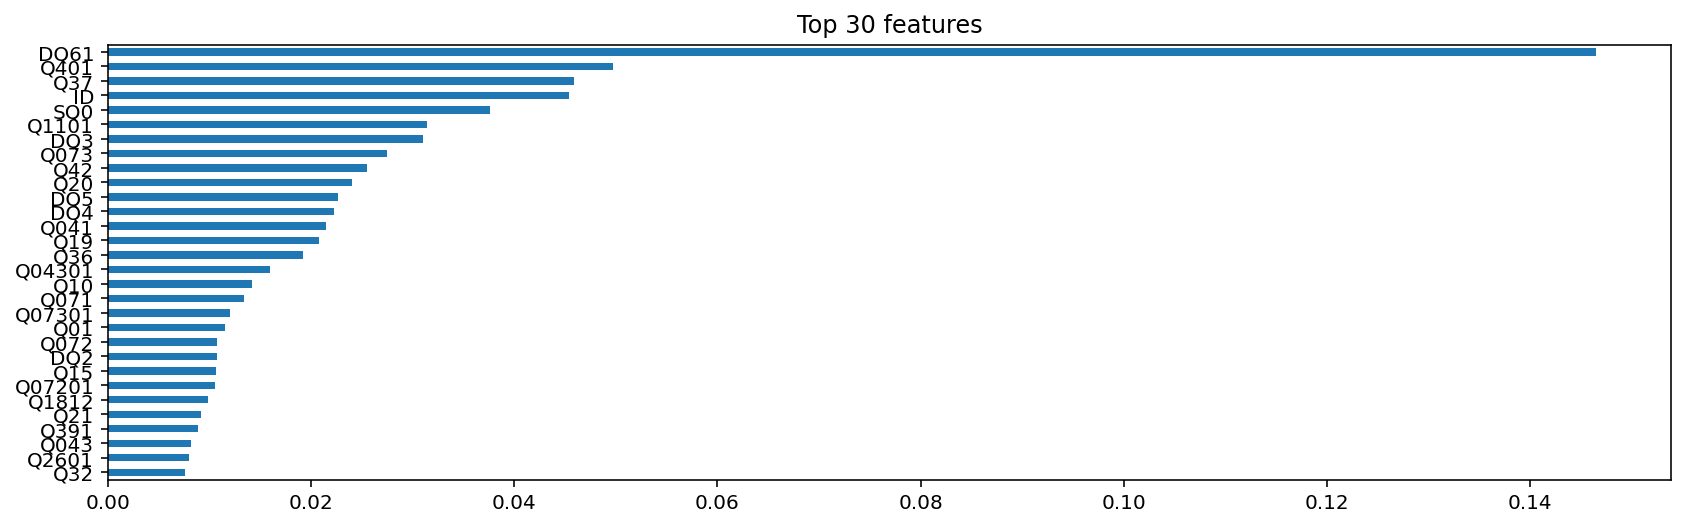

In [35]:
rf = pipe6.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 30
plt.figure(figsize=(14,4))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();
importances.sort_values()[-n:]

특성 중요도를 나열해본 결과 DQ61이 큰 부분을 차지합니다. 

(동의 정도) 여러 가지 면에서 내 인생은 이상적으로 생각했던 인생과 가깝다


In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


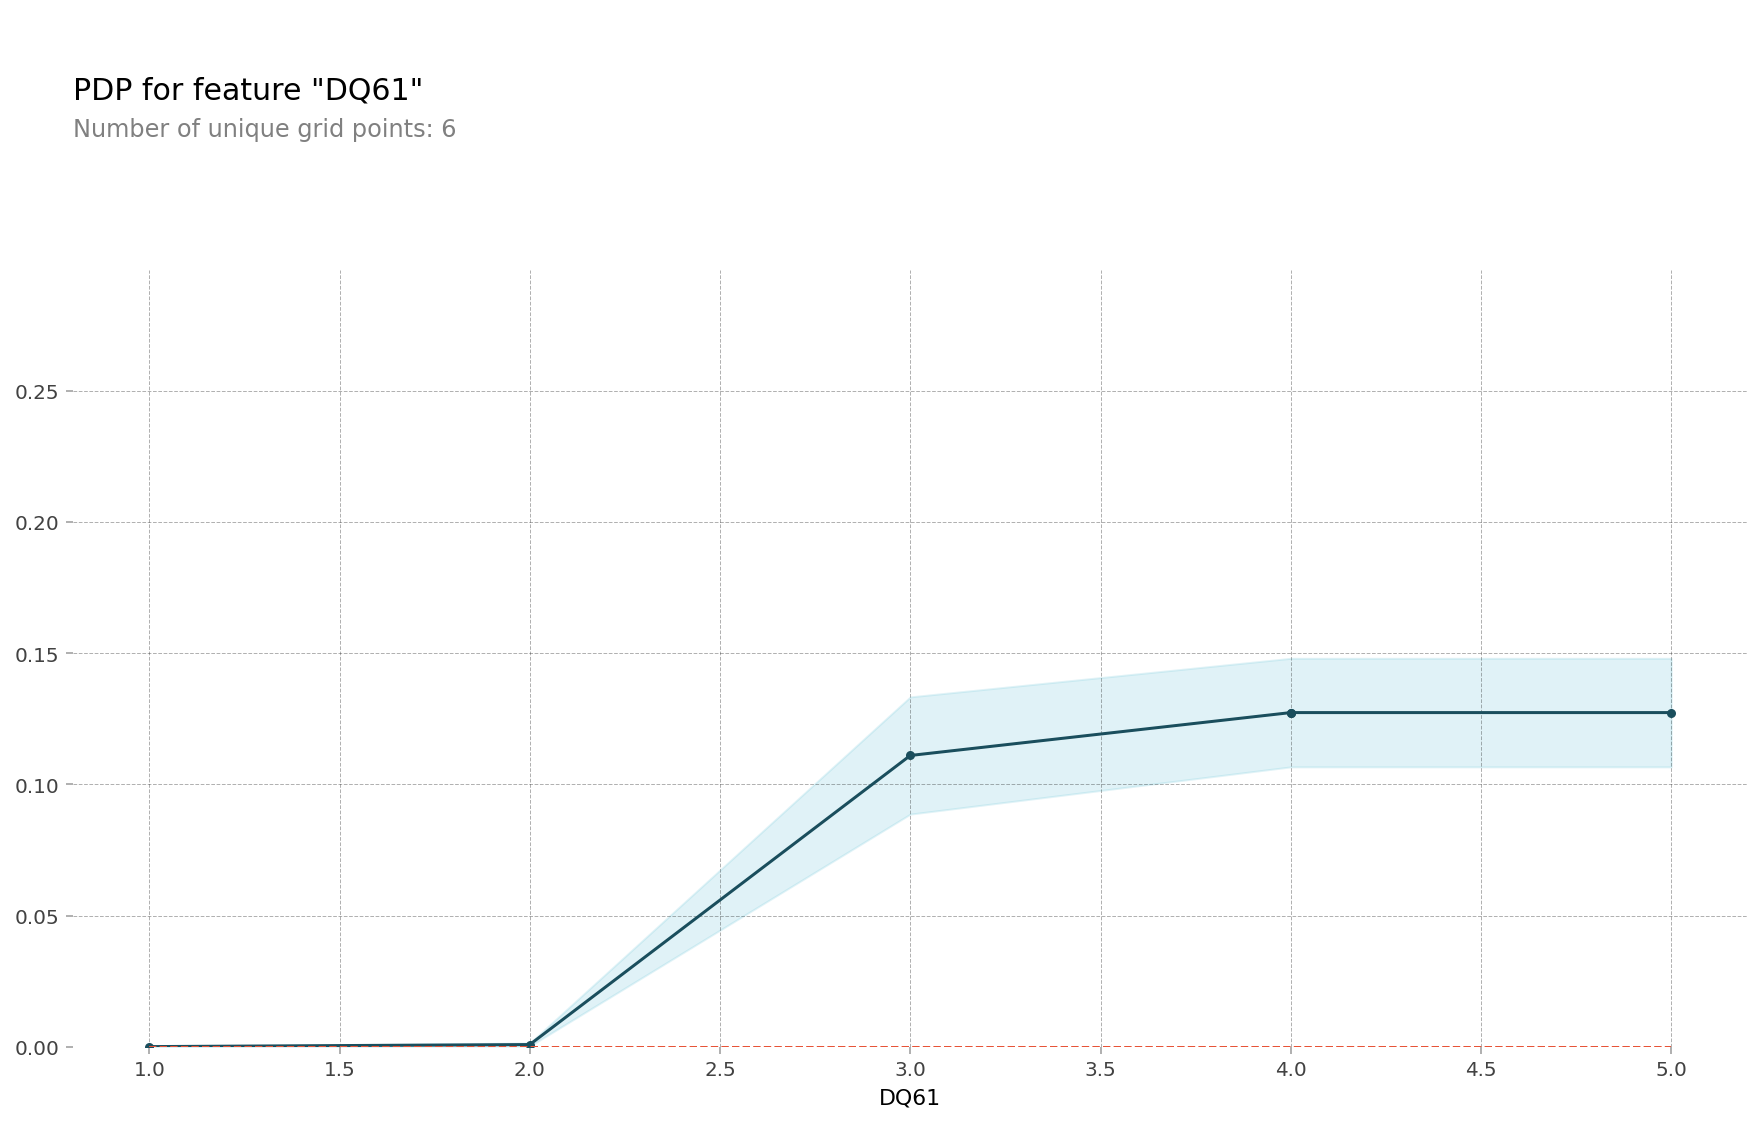

In [36]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'DQ61'

isolated = pdp_isolate(
    model=pipe6, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

DQ61이라는 (동의 정도) 여러 가지 면에서 내 인생은 이상적으로 생각했던 인생과 가깝다 값이 올라갈수록 모델의 성능도 변하는 것을 볼 수 있습니다.

SHAP

In [42]:
pip install xgboost

In [43]:
test_id = X_test['ID']

In [47]:

# 클래스의 비율
y_train.value_counts(normalize=True)


2    0.541916
1    0.458084
Name: DQ63, dtype: float64

In [46]:
ratio = 0.45/0.54
ratio

0.8333333333333333

In [49]:
target = 'DQ63'
X = df.drop(columns=target)
y = df[target]

In [53]:

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=100
    , stratify=y
    , random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=100
    , stratify=y_train_val
    , random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (323, 235)
y_train shape (323,)
X_val shape (100, 235)
y_val shape (100,)
X_test shape (100, 235)
y_test shape (100,)


In [55]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# XGBoost 분류기를 학습시킵니다. 클래스 비율을 맞추기 위해 scale_pos_weight= 삶에 불만족/ 삶에 만족 

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.936263	validation_1-auc:0.891103
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.944283	validation_1-auc:0.881039
[2]	validation_0-auc:0.951221	validation_1-auc:0.895733
[3]	validation_0-auc:0.951028	validation_1-auc:0.897343
[4]	validation_0-auc:0.951531	validation_1-auc:0.896538
[5]	validation_0-auc:0.951762	validation_1-auc:0.893317
[6]	validation_0-auc:0.959551	validation_1-auc:0.901771
[7]	validation_0-auc:0.965175	validation_1-auc:0.894122
[8]	validation_0-auc:0.967919	validation_1-auc:0.904187
[9]	validation_0-auc:0.968905	validation_1-auc:0.900966
[10]	validation_0-auc:0.970064	validation_1-auc:0.902577
[11]	validation_0-auc:0.972712	validation_1-auc:0.900966
[12]	validation_0-auc:0.97447	validation_1-auc:0.910427
[13]	validation_0-auc:0.975804	validation_1-auc:0.911634
[14]	validation_0-auc:0.97621	validation_1-auc:0.921095


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=0)

In [56]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "2":
0.8915056360708534


In [57]:

from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.86      0.78      0.82        46
           2       0.83      0.89      0.86        54

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



In [58]:
row1  = X_test.iloc[[1]] 

In [61]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row1_processed = processor.transform(row1)
shap_values = explainer.shap_values(row1_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row1, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [62]:
feature_names = row1.columns
feature_values = row1.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [63]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [64]:
print('Satisfied Life 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

Satisfied Life 예측에 대한 Positive 요인 Top 3 입니다:
1. Q2423 : 1
2. SQ0 : 5
3. DQ4 : 4


Negative 요인 Top 3 입니다:
1. DQ64 : 2
2. DQ62 : 2
3. DQ65 : 2


In [65]:
positive_class_index = 1
pred = model.predict(row1_processed)[0]
pred_proba = model.predict_proba(row1_processed)[0, positive_class_index]
pred_proba *= 100
print(f'303 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')

303 예측결과는 1 으로, 확률은 17% 입니다.
